In [208]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    "x1": load_data("../stats/fpm_4_2D_x1.json"),
    "x4": load_data("../stats/fpm_4_2D_x2.json"),
    "x9": load_data("../stats/fpm_4_2D_x3.json"),
    "x16": load_data("../stats/fpm_4_2D_x4.json"),
    "x25": load_data("../stats/fpm_4_2D_x5.json"),
    "x36": load_data("../stats/fpm_4_2D_x6.json"),
}

In [209]:
shape = [3, 2]
figsize = (12, 6)

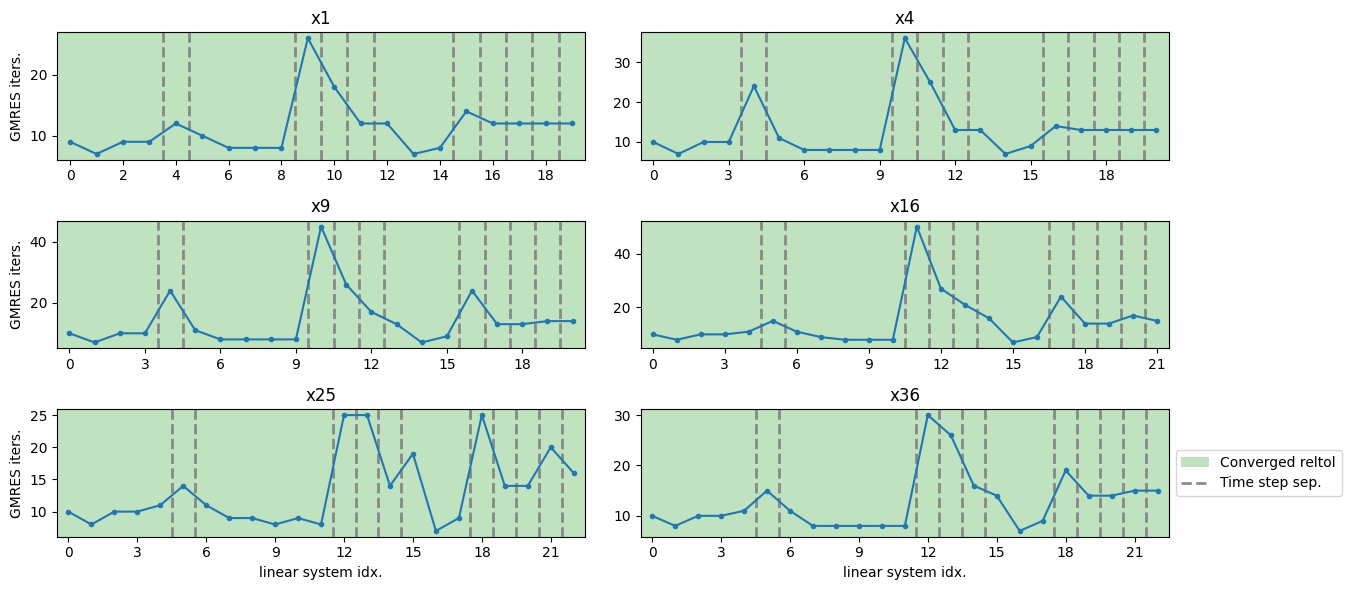

In [210]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker=".")


plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

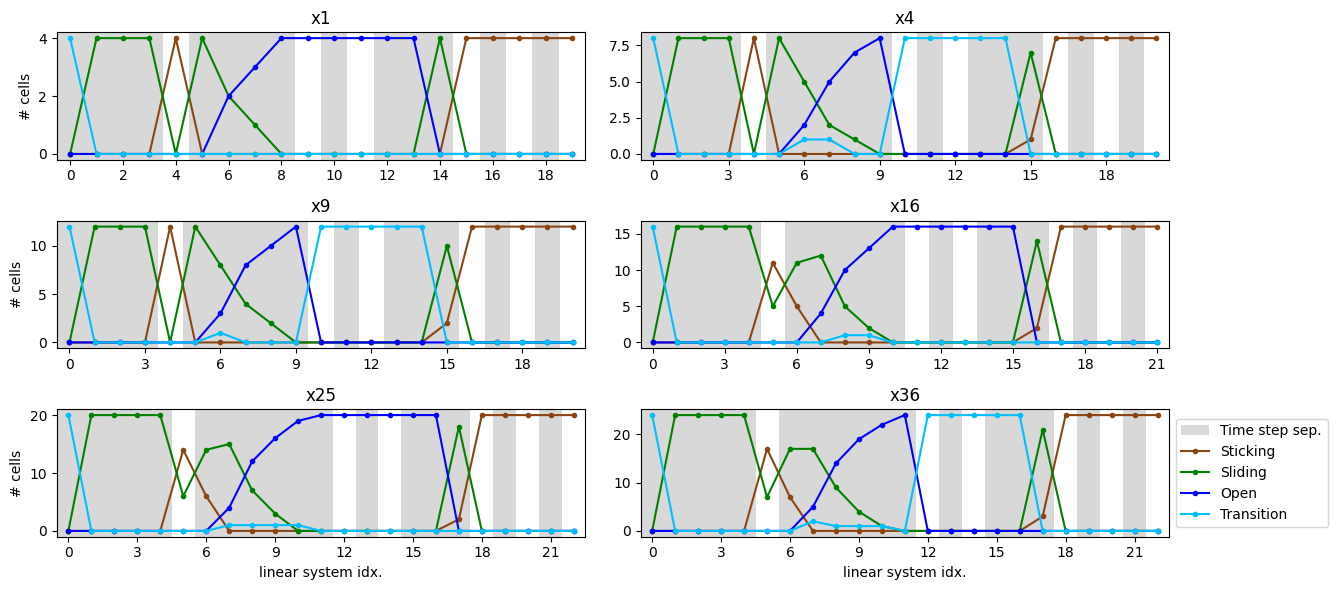

In [211]:
def render_element(entry: Sequence[TimeStepStats]):
    st, sl, op, tr = get_num_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.plot(st, label="Sticking", marker=".", color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=".", color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=".", color=COLOR_OPEN)
    plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel="# cells")

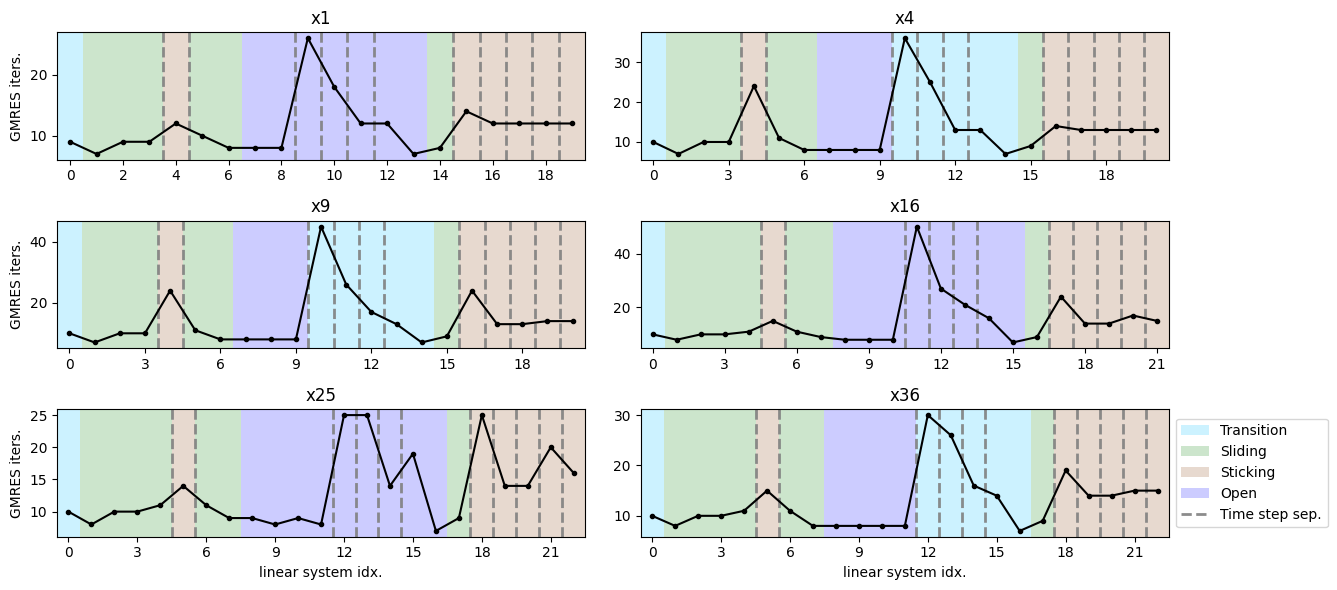

In [212]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker=".", color="black")
    # plt.ylim(top=15)


plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

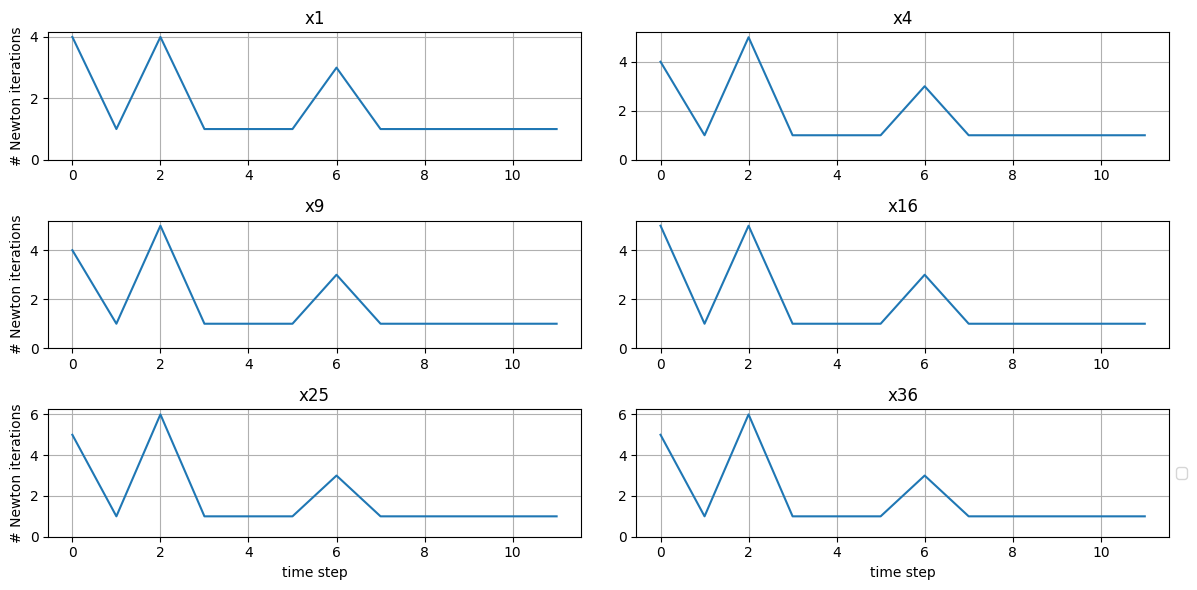

In [213]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()


plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="# Newton iterations",
    xlabel="time step",
)

Text(0.5, 0, 'Simulation time, s')

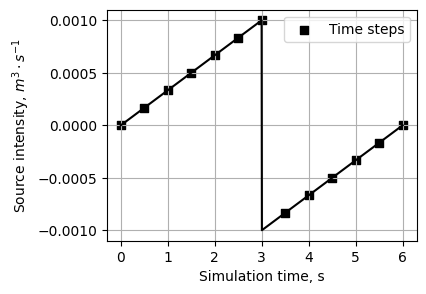

In [214]:
from fpm_4_2D import make_model

model = make_model(cell_size_multiplier=1)
model.prepare_simulation()
source = []
t_list = np.linspace(0, 6, 13, endpoint=True)
for t in t_list:
    source.append(model.get_source_intensity(t))

source_fine = []
t_list_fine = np.linspace(0, 6, 1000, endpoint=True)
for t in t_list_fine:
    source_fine.append(model.get_source_intensity(t))

plt.figure(figsize=(4, 3))
plt.plot(t_list_fine, source_fine, color="black")
plt.scatter(t_list, source, marker="s", label="Time steps", color="black")
plt.grid()
plt.legend()
plt.ylabel(r"Source intensity, $m^3 \cdot s^{-1}$")
plt.xlabel("Simulation time, s")

# Testing bad matrix

In [215]:
assert False

AssertionError: 

In [ ]:
from fpm_4_2D import make_model

model = make_model(cell_size_multiplier=4)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 0
num sliding: 0
num open: 0
num transition: 16


In [ ]:
mat_idx = 12
entry = data["x16"]
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

61


In [ ]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

0
0
16
0


Solve  took: 3.25
True residual permuted: 5.7368189273325196e-08
PETSc Converged Reason: -3
lambda min: 0.4647089227716373


{'mat_Q': BlockMatrixStorage of shape (11280, 11280) with 424589 elements with 6x6 active groups}

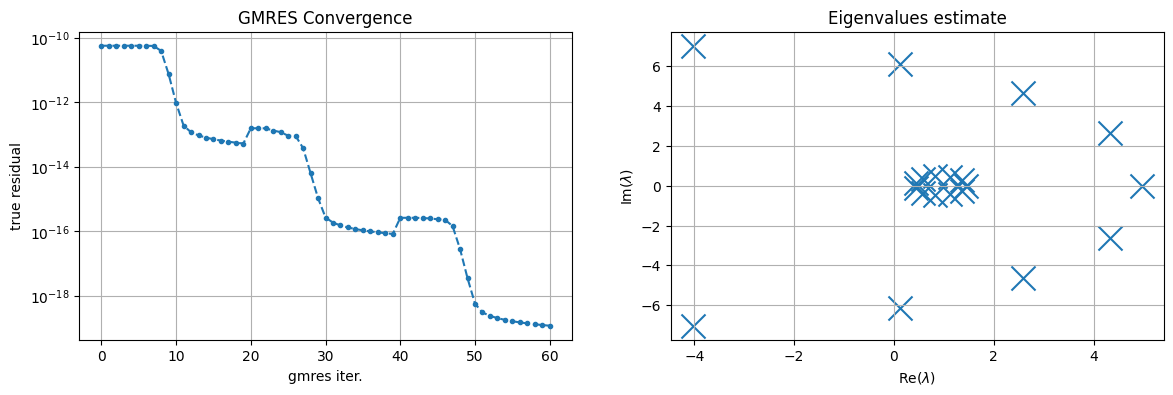

In [ ]:
sol = None
schema = model._prepare_solver()
solve_petsc_new(
    model.bmat,
    schema,
    rhs_global=rhs,
    # Qleft=model.Qleft,
    # Qright=model.Qright,
    pc_side="right",
    tol=1e-10,
)

In [ ]:
J = model.bmat

Solve  took: 0.34
True residual permuted: 1.3881025410595512e-11
PETSc Converged Reason: 2


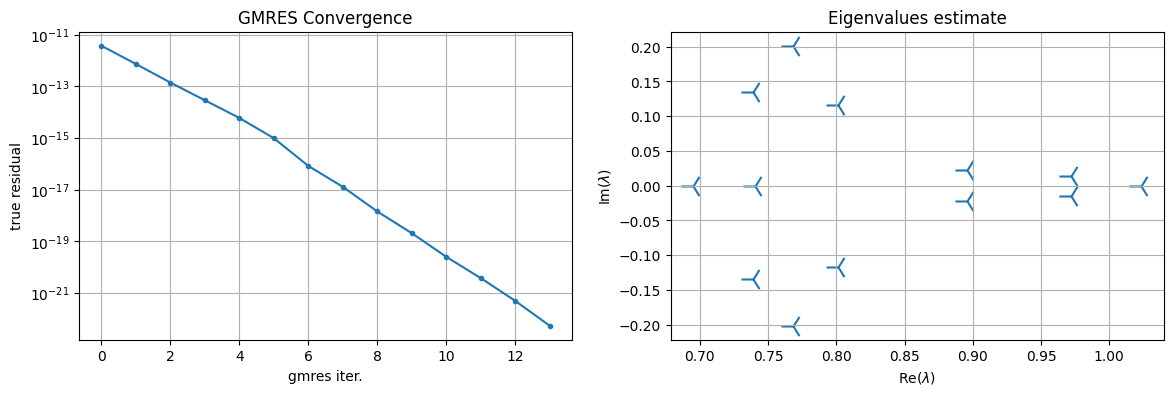

In [ ]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import *

schema = SolveSchema(
    # groups=[4],
    # solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    # complement=SolveSchema(
        # groups=[3],
        # solve=lambda bmat: PetscILU(bmat[[3]].mat),
        # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # complement=SolveSchema(
            groups=[5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[5]].mat, dim=model.nd),
            invertor=lambda bmat: inv_block_diag(
                mat=bmat[[5]].mat, nd=model.nd, lump=True
            ),
            complement=SolveSchema(
                groups=[1],
                solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1]].mat, dim=model.nd),
                invertor_type="physical",
                # invertor=lambda bmat: make_fs_experimental(model, J)[[2]].mat,
                # complement=SolveSchema(
                #     groups=[2],
                #     solve=lambda bmat: PetscAMGFlow(mat=bmat[[2]].mat),
                # ),
            ),
        # ),
    # ),
)

res = solve_petsc_new(
    model.bmat,
    schema,
    # Qleft=model.Qleft,
    # Qright=model.Qright,
    rhs_global=rhs,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)